In [25]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

import torch
import torch.optim as optim
import torch.nn.functional as F

import torch_frame
from torch_frame import stype
from torch_frame.data.loader import DataLoader
from torch_frame.nn.models.trompt import Trompt
from torch_frame.data.stats import compute_col_stats
from torch_frame.data import DataFrameToTensorFrameConverter

from utils import SOSEncoder, TargetEncoder

import warnings
warnings.filterwarnings('ignore')

print("PyTorch       version:", torch.__version__)
print("PyTorch Frame version:", torch_frame.__version__)

PyTorch       version: 2.5.1+cu121
PyTorch Frame version: 0.3.0


## Configuration

In [26]:
DIR = 'D:\\PPrograms\\Python\\Kaggle\\Predicting Loan Pay\\'
TARGET = 'loan_paid_back'
SEED = 42

In [27]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed) # prevent python from randomly hashing, ensure the iteration order of dict, set and so on
    random.seed(seed) # random package
    np.random.seed(seed) # np.random package
    torch.manual_seed(seed) # random number generator on CPU
    torch.cuda.manual_seed_all(seed) # random number generator on GPU
    torch.backends.cudnn.benchmark = False # forbid CuDNN to search for best algorithm
    torch.backends.cudnn.deterministic = True # enforce CuDNN search for determinate algorithm
seed_everything(seed=SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
train = pd.read_csv(os.path.join(DIR, 'data\\train.csv'), index_col='id')
train, valid = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[TARGET])
test = pd.read_csv(os.path.join(DIR, 'data\\test.csv'), index_col='id')

In [29]:
def calculate_class_weights(y):
    """Inverse classes weight"""
    class_counts = np.bincount(y)
    total_samples = len(y)
    num_classes = len(class_counts)

    weights = total_samples / (num_classes * class_counts)

    return torch.tensor(weights, dtype=torch.float)

class_weights = calculate_class_weights(train[TARGET]).to(device)
print(f'Class weights:\n{class_weights}')

Class weights:
tensor([2.4853, 0.6259], device='cuda:0')


In [30]:
NUM = [col for col in test.columns if train[col].dtypes in ('float64', 'int64')]
CAT = [col for col in test.columns if train[col].dtypes in ('object',)]
COL = NUM + CAT
print(f'There are {test.shape[1]} cols, in which {len(NUM)} are numerical and {len(CAT)} are categorical.')

There are 11 cols, in which 5 are numerical and 6 are categorical.


## Feature Engineering
### Frequency

In [31]:
FREQ = []

sos = SOSEncoder(20)
def generate_frequency_feature(df, *df_other):
    train = pd.DataFrame(index=df.index)
    other = [pd.DataFrame(index=_.index) for _ in df_other]

    for col in COL:
        # --- Frequency Features ---
        # count the number of occurrences of each unique values
        freq= df[col].value_counts()
        col_name = f'{col}_freq'
        train[col_name] = df[col].map(freq)
        for i in range(len(other)):
            other[i][col_name] = df_other[i][col].map(freq).fillna(freq.mean())
        FREQ.append(col_name)
        # --- Bin Features ---
        # split the numerical col into bins
        if col in NUM:
            for q in [5, 10, 15]:
                train_bins, bins = pd.cut(df[col], bins=q, labels=False, retbins=True, duplicates="drop")
                col_name = f'{col}_bins{q}'
                train[col_name] = train_bins
                for i in range(len(other)):
                    other[i][col_name] = pd.cut(df_other[i][col], bins=bins, labels=False, duplicates="drop", include_lowest=True)

                FREQ.append(col_name)
    # --- Weighted Bins Features ---
    # split the numerical col into bins while label there weight
    res = sos.fit_transform(df[NUM])
    train = train.join(res)
    for i in range(len(other)):
        res = sos.transform(df_other[i][NUM])
        other[i] = other[i].join(res)

    FREQ.extend(sos.res_columns)

    # concatenate all features at once
    df = pd.concat([df, train], axis=1)
    for i in range(len(other)):
        other[i] = pd.concat([df_other[i], other[i]], axis=1)
    return df, *other

train, test, valid = generate_frequency_feature(train, *[test, valid])
print(f'{len(FREQ)} Frequency features created.')

136 Frequency features created.


### Subgrade

In [32]:
SUBGRADE = []

def generate_subgrade_feature(df, *df_other):


    df['grade'] = df['grade_subgrade'].str[0].astype('category')
    df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
    for data in df_other:
        data['grade'] = data['grade_subgrade'].str[0].astype('category')
        data['subgrade'] = data['grade_subgrade'].str[1:].astype(int)
    SUBGRADE.append('grade')
    SUBGRADE.append('subgrade')

    return df, *df_other

train, test, valid = generate_subgrade_feature(train, *[test, valid])
print(f'{len(SUBGRADE)} Subgrade features created.')

2 Subgrade features created.


### OrdCategory

In [33]:
ORDCATE = []
def generate_ordcategory_feature(df, *df_other):
    edu_map = {
        "Other": 0,
        "High School": 1,
        "Bachelor's": 2,
        "Master's": 3,
        "PhD": 4,
    }
    emp_map = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 4,
    }
    grade_map = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
    }
    for data in [df, *df_other]:
        data['ordered_edu_level'] = data['education_level'].map(edu_map)
        data['ordered_employment_status'] = data['employment_status'].map(emp_map)
        data['ordered_grade'] = df['grade_subgrade'].str[0].map(grade_map)
    ORDCATE.append('ordered_edu_level')
    ORDCATE.append('ordered_employment_status')
    ORDCATE.append('ordered_grade')

    return df, *df_other

train, test, valid = generate_ordcategory_feature(train, test, valid)
print(f'{len(ORDCATE)} Ordcategory features created.')

3 Ordcategory features created.


### Quadratic

In [34]:
INTER = []

def generate_quadratic_feature(df, *df_other):
    # values of fea 'annual_income' and 'loan_amount' are too much ,and they are not important in statistics in the meantime
    quadra_cols = combinations([col for col in COL if col not in ('annual_income', 'loan_amount')], 2)
    for col1, col2 in quadra_cols:
        col = f'{col1}_{col2}'
        for data in [df, *df_other]:
            data[col] = data[col1].astype(str) + '_' + data[col2].astype(str)
            data[col] = data[col].astype('category')
        INTER.append(col)

    return df, *df_other

train, test, valid = generate_quadratic_feature(train, test, valid)
print(f'{len(INTER)} Inter features created.')

36 Inter features created.


### Round

In [35]:
ROUND = []

def generate_round_feature(df, *df_other):
    rounding_levels = {
        '1r': 0,
        '10r': -1,
        '100r': -2
    }
    for col in ['annual_income', 'loan_amount']:
        for suffix, level in rounding_levels.items():
            col_name = f'{col}_{suffix}'
            for data in [df, *df_other]:
                data[col_name] = data[col].round(level).astype(int)

            ROUND.append(col_name)
    return df, *df_other

train, test, valid = generate_round_feature(train, test, valid)
print(f'{len(ROUND)} Round features created.')

6 Round features created.


### Target

In [36]:
TAR = []

tar = TargetEncoder(cols_to_encode=COL, aggs=['mean', 'count'], drop_original=True)
def generate_target_feature(df, *df_other):
    other = list(df_other)

    df_tar = tar.fit_transform(df[COL], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(tar.transform(other[i][COL]))
    TAR.extend(df_tar.columns)

    return df, *other

train, test, valid = generate_target_feature(train, test, valid)
print(f'{len(TAR)} Target features created.')

22 Target features created.


### Inter Target

In [37]:
INTERTAR = []

intertar = TargetEncoder(cols_to_encode=INTER, aggs=['mean', 'count'], drop_original=True)
def generate_inter_target_feature(df, *df_other):
    other = list(df_other)

    # astype category to str, later change them back
    cate_cols = [i for i, x in df.dtypes.items() if x == 'category']
    for col in cate_cols:
        df[col] = df[col].astype(str)
        for i in range(len(other)):
            other[i][col] = other[i][col].astype(str)

    df_tar = intertar.fit_transform(df[INTER], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(intertar.transform(other[i][INTER]))
    INTERTAR.extend(df_tar.columns)

    for col in cate_cols:
        df[col] = df[col].astype('category')
        for i in range(len(other)):
            other[i][col] = other[i][col].astype('category')

    return df, *other

train, test, valid = generate_inter_target_feature(train, test, valid)
print(f'{len(INTERTAR)} Inter Target features created.')

72 Inter Target features created.


### Round Target

In [38]:
ROUNDTAR = []

roundtar = TargetEncoder(cols_to_encode=ROUND, aggs=['mean', 'count'], drop_original=True)
def generate_round_target_feature(df, *df_other):
    other = list(df_other)

    df_tar = roundtar.fit_transform(df[ROUND], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(roundtar.transform(other[i][ROUND]))
    ROUNDTAR.extend(df_tar.columns)

    return df, *other

train, test, valid = generate_round_target_feature(train, test, valid)
print(f'{len(ROUNDTAR)} Round Target features created.')

12 Round Target features created.


In [39]:
for col in CAT:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    valid[col] = valid[col].astype('category')

In [40]:
FEATURES = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE + INTERTAR + ROUNDTAR
print(len(FEATURES), 'Features.')

264 Features.


## Trompt Configuration

In [41]:
# You can use Bayesian optimization to search a better parameter combinations
class CFG:
    FOLDS = 5
    EPOCHS = 4
    LR = 1e-3
    WD = 1e-4
    WARMUP = 0.2
    BATCH = 512
    CHANNELS = 64
    PROMPTS = 8
    LAYERS = 4

## Trompt Model

In [42]:
%%time

used_feas = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE
col_to_stype = {c: stype.categorical for c in used_feas if train[c].dtype == 'category'}
col_to_stype.update({
    c: stype.numerical for c in used_feas if train[c].dtype != 'category'
})
col_to_stype[TARGET] = stype.numerical

skf = StratifiedKFold(n_splits=CFG.FOLDS, shuffle=True, random_state=42)
train_fsp = np.zeros(len(train))
val_fsp = np.zeros(len(valid))
test_fsp = np.zeros(len(test))

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[TARGET]), 1):
    print(f"\n--- Fold {fold}/{CFG.FOLDS} ---")

    X_train, X_valid = train[used_feas+[TARGET]].iloc[train_idx], train[used_feas+[TARGET]].iloc[valid_idx]

    # Calculate statistic feature for numerical and categorical columns
    # These statistic information will be used to standardization numerical columns and one-hot encode categorical columns
    col_stats = {c: compute_col_stats(X_train[c], stype=col_to_stype[c]) for c in X_train.columns if c in col_to_stype}

    # Transfer DataFrame to Tensor
    converter = DataFrameToTensorFrameConverter(col_stats=col_stats, target_col=TARGET, col_to_stype=col_to_stype)
    tf_train = converter(X_train)
    tf_valid   = converter(X_valid)
    tf_val = converter(valid[used_feas])
    tf_test  = converter(test[used_feas])

    train_loader = DataLoader(tf_train, batch_size=CFG.BATCH, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(tf_valid, batch_size=CFG.BATCH, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(tf_val, batch_size=CFG.BATCH, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(tf_test, batch_size=CFG.BATCH, shuffle=False, pin_memory=True)

    model = Trompt(
        channels=CFG.CHANNELS, # feature channels
        out_channels=2, # output channels
        num_prompts=CFG.PROMPTS, # prompt number
        num_layers=CFG.LAYERS, # model layer number
        col_stats=col_stats, # columns statistics
        col_names_dict=converter.col_names_dict
    ).to(device)

    total_steps = len(train_loader) * CFG.EPOCHS
    # Use Adam as parameter optimizer and the learning rate follows OneCycle principle(warming-up)
    # Update the learning rate on each batch
    optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.LR, total_steps=total_steps,
                                                    pct_start=CFG.WARMUP, cycle_momentum=False)
    for epoch in range(1, CFG.EPOCHS + 1):
        model.train()
        total_loss = 0.0
        total_samples = 0

        for batch in train_loader:
            batch = batch.to(device, non_blocking=True)
            optimizer.zero_grad()

            # Compute layer-wise supervised loss
            out = model(batch)
            batch_size, num_layers, num_classes = out.size()
            # [batch_size * num_layers, num_classes]
            pred = out.view(-1, num_classes)
            # [batch_size * num_layers] (ints)
            y_rep = batch.y.long().repeat_interleave(num_layers)
            loss = F.cross_entropy(pred, y_rep, weight=class_weights)

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * batch_size
            total_samples += batch_size
        avg_loss = total_loss / (total_samples + 1e-12)

        # Validation: average across layers, then compute positive-class prob
        model.eval()
        val_probs_parts = []
        val_targets_parts = []
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device, non_blocking=True)
                preds = model(batch).mean(dim=1)            # Average layers
                probs = torch.softmax(preds, dim=-1)[:, 1]  # Positive class prob
                val_probs_parts.append(probs.cpu().numpy())
                val_targets_parts.append(batch.y.cpu().numpy())

        val_probs = np.concatenate(val_probs_parts)
        val_targets = np.concatenate(val_targets_parts)
        val_auc = roc_auc_score(val_targets, val_probs)
        print(f"    Epoch {epoch:02d} - train_loss: {avg_loss:.5f} val_auc: {val_auc:.5f}")

    # After training fold: produce test valid preds for this fold
    model.eval()
    fold_val_probs = []
    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device, non_blocking=True)
            preds = model(batch).mean(dim=1)
            probs = torch.softmax(preds, dim=-1)[:, 1]
            fold_val_probs.append(probs.cpu().numpy())
    fold_val_probs = np.concatenate(fold_val_probs)
    train_fsp[valid_idx] = fold_val_probs

    # Predict test and val set inside fold and average across folds
    fold_test_preds = []
    fold_val_preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device, non_blocking=True)
            preds = model(batch).mean(dim=1)
            probs = torch.softmax(preds, dim=-1)[:, 1]
            fold_test_preds.append(probs.cpu().numpy())
        for batch in val_loader:
            batch = batch.to(device, non_blocking=True)
            preds = model(batch).mean(dim=1)
            probs = torch.softmax(preds, dim=-1)[:, 1]
            fold_val_preds.append(probs.cpu().numpy())
    fold_test_preds = np.concatenate(fold_test_preds)
    fold_val_preds = np.concatenate(fold_val_preds)
    test_fsp += fold_test_preds / CFG.FOLDS
    val_fsp += fold_val_preds / CFG.FOLDS
    print(f"\n{'='*30}")
    auc = roc_auc_score(valid[TARGET], fold_val_preds)
    acc = accuracy_score(valid[TARGET], (fold_val_preds > 0.5).astype(int))
    f1 = f1_score(valid[TARGET], (fold_val_preds > 0.5).astype(int))
    print(f'Fold {fold}/{CFG.FOLDS} On Valid Data AUC = {auc:.05f} ACC = {acc:.05f} F1 = {f1:.05f}')
    print('='*30)

print(f"\nFINAL METRICS ON VALID DATA: AUC = {roc_auc_score(valid[TARGET], val_fsp)} ACC = {accuracy_score(valid[TARGET], (val_fsp > 0.5).astype(int))} F1 = {f1_score(valid[TARGET], (val_fsp > 0.5).astype(int))}.\n")


--- Fold 1/5 ---
    Epoch 01 - train_loss: 0.38879 val_auc: 0.91728
    Epoch 02 - train_loss: 0.36151 val_auc: 0.91856
    Epoch 03 - train_loss: 0.35666 val_auc: 0.92017
    Epoch 04 - train_loss: 0.35275 val_auc: 0.92061

Fold 1/5 On Valid Data AUC = 0.91856 ACC = 0.86047 F1 = 0.90946

--- Fold 2/5 ---
    Epoch 01 - train_loss: 0.41382 val_auc: 0.91746
    Epoch 02 - train_loss: 0.37023 val_auc: 0.91871
    Epoch 03 - train_loss: 0.36129 val_auc: 0.92029
    Epoch 04 - train_loss: 0.35461 val_auc: 0.92071

Fold 2/5 On Valid Data AUC = 0.91999 ACC = 0.86456 F1 = 0.91234

--- Fold 3/5 ---
    Epoch 01 - train_loss: 0.39646 val_auc: 0.91752
    Epoch 02 - train_loss: 0.36524 val_auc: 0.91957
    Epoch 03 - train_loss: 0.35539 val_auc: 0.92160
    Epoch 04 - train_loss: 0.34945 val_auc: 0.92190

Fold 3/5 On Valid Data AUC = 0.92175 ACC = 0.87540 F1 = 0.92018

--- Fold 4/5 ---
    Epoch 01 - train_loss: 0.39311 val_auc: 0.91517
    Epoch 02 - train_loss: 0.36521 val_auc: 0.91895
    E

Confusion Matrix:
[[18728  5172]
 [10018 84881]]


Text(0.5, 1.0, 'confussion')

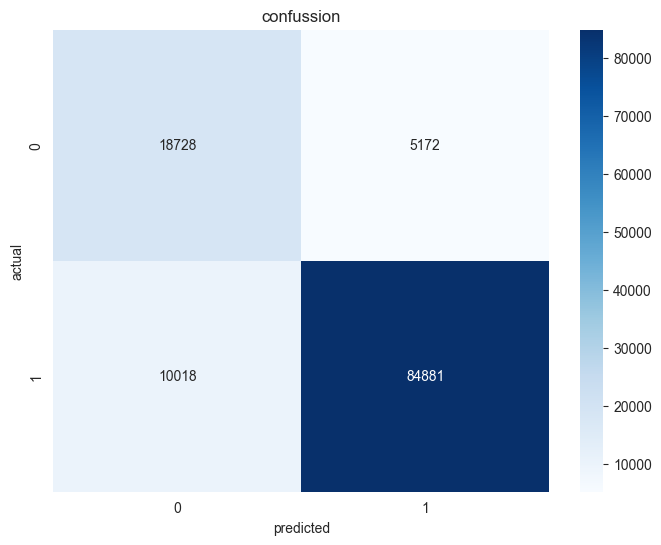

In [43]:
# Compute confusion matrix
cm = confusion_matrix(valid[TARGET], (val_fsp > 0.5).astype(int))
print("Confusion Matrix:")
print(cm)

# visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

In [46]:
# Save the results
pd.DataFrame(data={'id': test.index, TARGET: test_fsp}).to_csv(os.path.join(DIR, 'sub\\trompt\\test_fsp.csv'), index=False, header=True)
pd.DataFrame(data={'id': train.index, TARGET: train_fsp}).to_csv(os.path.join(DIR, 'sub\\trompt\\train_fsp.csv'), index=False, header=True)
pd.DataFrame(data={'id': valid.index, TARGET: val_fsp}).to_csv(os.path.join(DIR, 'sub\\trompt\\valid_fsp.csv'), index=False, header=True)

## Residual Model

In [47]:
pre_prev_train = pd.read_csv(os.path.join(DIR, 'sub\\trompt\\train_fsp.csv'), index_col='id')
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\trompt\\valid_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\trompt\\test_fsp.csv'), index_col='id')

In [48]:
# Add the logits predicted as a feature
def inv_sigmoid(X):
    return -np.log(1/X - 1)

RESID = ['RESID']

train['RESID'] = inv_sigmoid(pre_prev_train)
valid['RESID'] = inv_sigmoid(pre_prev_valid)
test['RESID'] = inv_sigmoid(pre_prev_test)

In [50]:
%%time

used_feas = INTERTAR + RESID + TAR + FREQ + ROUNDTAR
col_to_stype = {c: stype.categorical for c in used_feas if train[c].dtype == 'category'}
col_to_stype.update({
    c: stype.numerical for c in used_feas if train[c].dtype != 'category'
})
col_to_stype[TARGET] = stype.numerical

skf = StratifiedKFold(n_splits=CFG.FOLDS, shuffle=True, random_state=42)
train_ssp = np.zeros(len(train))
val_ssp = np.zeros(len(valid))
test_ssp = np.zeros(len(test))

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[TARGET]), 1):
    print(f"\n--- Fold {fold}/{CFG.FOLDS} ---")

    X_train, X_valid = train[used_feas+[TARGET]].iloc[train_idx], train[used_feas+[TARGET]].iloc[valid_idx]

    # Calculate statistic feature for numerical and categorical columns
    # These statistic information will be used to standardization numerical columns and one-hot encode categorical columns
    col_stats = {c: compute_col_stats(X_train[c], stype=col_to_stype[c]) for c in X_train.columns if c in col_to_stype}

    # Transfer DataFrame to Tensor
    converter = DataFrameToTensorFrameConverter(col_stats=col_stats, target_col=TARGET, col_to_stype=col_to_stype)
    tf_train = converter(X_train)
    tf_valid   = converter(X_valid)
    tf_val = converter(valid[used_feas])
    tf_test  = converter(test[used_feas])

    train_loader = DataLoader(tf_train, batch_size=CFG.BATCH, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(tf_valid, batch_size=CFG.BATCH, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(tf_val, batch_size=CFG.BATCH, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(tf_test, batch_size=CFG.BATCH, shuffle=False, pin_memory=True)

    model = Trompt(
        channels=CFG.CHANNELS, # feature channels
        out_channels=2, # output channels
        num_prompts=CFG.PROMPTS, # prompt number
        num_layers=CFG.LAYERS, # model layer number
        col_stats=col_stats, # columns statistics
        col_names_dict=converter.col_names_dict
    ).to(device)

    total_steps = len(train_loader) * CFG.EPOCHS
    # Use Adam as parameter optimizer and the learning rate follows OneCycle principle(warming-up)
    # Update the learning rate on each batch
    optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.LR, total_steps=total_steps,
                                                    pct_start=CFG.WARMUP, cycle_momentum=False)
    for epoch in range(1, CFG.EPOCHS + 1):
        model.train()
        total_loss = 0.0
        total_samples = 0

        for batch in train_loader:
            batch = batch.to(device, non_blocking=True)
            optimizer.zero_grad()

            # Compute layer-wise supervised loss
            out = model(batch)
            batch_size, num_layers, num_classes = out.size()
            # [batch_size * num_layers, num_classes]
            pred = out.view(-1, num_classes)
            # [batch_size * num_layers] (ints)
            y_rep = batch.y.long().repeat_interleave(num_layers)
            loss = F.cross_entropy(pred, y_rep, weight=class_weights)

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * batch_size
            total_samples += batch_size
        avg_loss = total_loss / (total_samples + 1e-12)

        # Validation: average across layers, then compute positive-class prob
        model.eval()
        val_probs_parts = []
        val_targets_parts = []
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device, non_blocking=True)
                preds = model(batch).mean(dim=1)            # Average layers
                probs = torch.softmax(preds, dim=-1)[:, 1]  # Positive class prob
                val_probs_parts.append(probs.cpu().numpy())
                val_targets_parts.append(batch.y.cpu().numpy())

        val_probs = np.concatenate(val_probs_parts)
        val_targets = np.concatenate(val_targets_parts)
        val_auc = roc_auc_score(val_targets, val_probs)
        print(f"    Epoch {epoch:02d} - train_loss: {avg_loss:.5f} val_auc: {val_auc:.5f}")

    # After training fold: produce test valid preds for this fold
    model.eval()
    fold_val_probs = []
    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device, non_blocking=True)
            preds = model(batch).mean(dim=1)
            probs = torch.softmax(preds, dim=-1)[:, 1]
            fold_val_probs.append(probs.cpu().numpy())
    fold_val_probs = np.concatenate(fold_val_probs)
    train_ssp[valid_idx] = fold_val_probs

    # Predict test and val set inside fold and average across folds
    fold_test_preds = []
    fold_val_preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device, non_blocking=True)
            preds = model(batch).mean(dim=1)
            probs = torch.softmax(preds, dim=-1)[:, 1]
            fold_test_preds.append(probs.cpu().numpy())
        for batch in val_loader:
            batch = batch.to(device, non_blocking=True)
            preds = model(batch).mean(dim=1)
            probs = torch.softmax(preds, dim=-1)[:, 1]
            fold_val_preds.append(probs.cpu().numpy())
    fold_test_preds = np.concatenate(fold_test_preds)
    fold_val_preds = np.concatenate(fold_val_preds)
    test_ssp += fold_test_preds / CFG.FOLDS
    val_ssp += fold_val_preds / CFG.FOLDS
    print(f"\n{'='*30}")
    auc = roc_auc_score(valid[TARGET], fold_val_preds)
    acc = accuracy_score(valid[TARGET], (fold_val_preds > 0.5).astype(int))
    f1 = f1_score(valid[TARGET], (fold_val_preds > 0.5).astype(int))
    print(f'Fold {fold}/{CFG.FOLDS} On Valid Data AUC = {auc:.05f} ACC = {acc:.05f} F1 = {f1:.05f}')
    print('='*30)

print(f"\nFINAL METRICS ON VALID DATA: AUC = {roc_auc_score(valid[TARGET], val_ssp)} ACC = {accuracy_score(valid[TARGET], (val_ssp > 0.5).astype(int))} F1 = {f1_score(valid[TARGET], (val_ssp > 0.5).astype(int))}.\n")


--- Fold 1/5 ---
    Epoch 01 - train_loss: 0.37351 val_auc: 0.92148
    Epoch 02 - train_loss: 0.35122 val_auc: 0.92366
    Epoch 03 - train_loss: 0.34436 val_auc: 0.92481
    Epoch 04 - train_loss: 0.34043 val_auc: 0.92528

Fold 1/5 On Valid Data AUC = 0.92458 ACC = 0.86593 F1 = 0.91304

--- Fold 2/5 ---
    Epoch 01 - train_loss: 0.36891 val_auc: 0.92243
    Epoch 02 - train_loss: 0.34825 val_auc: 0.92402
    Epoch 03 - train_loss: 0.34321 val_auc: 0.92491
    Epoch 04 - train_loss: 0.33960 val_auc: 0.92530

Fold 2/5 On Valid Data AUC = 0.92507 ACC = 0.87255 F1 = 0.91787

--- Fold 3/5 ---
    Epoch 01 - train_loss: 0.37467 val_auc: 0.91997
    Epoch 02 - train_loss: 0.35669 val_auc: 0.92260
    Epoch 03 - train_loss: 0.34809 val_auc: 0.92424
    Epoch 04 - train_loss: 0.34371 val_auc: 0.92454

Fold 3/5 On Valid Data AUC = 0.92417 ACC = 0.86715 F1 = 0.91394

--- Fold 4/5 ---
    Epoch 01 - train_loss: 0.37745 val_auc: 0.92253
    Epoch 02 - train_loss: 0.35209 val_auc: 0.92471
    E

In [51]:
# Save the results
pd.DataFrame(data={'id': test.index, TARGET: test_ssp}).to_csv(os.path.join(DIR, 'sub\\trompt\\test_ssp.csv'), index=False, header=True)
pd.DataFrame(data={'id': train.index, TARGET: train_ssp}).to_csv(os.path.join(DIR, 'sub\\trompt\\train_ssp.csv'), index=False, header=True)
pd.DataFrame(data={'id': valid.index, TARGET: val_ssp}).to_csv(os.path.join(DIR, 'sub\\trompt\\valid_ssp.csv'), index=False, header=True)